In [19]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torch import nn
import torch.nn.init as init
import typing
import utils
import time
import collections
from dataloaders_task4 import load_cifar10

def compute_loss_and_accuracy(
        dataloader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        loss_criterion: torch.nn.modules.loss._Loss):
    """
    Computes the average loss and the accuracy over the whole dataset
    in dataloader.
    Args:
        dataloder: Validation/Test dataloader
        model: torch.nn.Module
        loss_criterion: The loss criterion, e.g: torch.nn.CrossEntropyLoss()
    Returns:
        [average_loss, accuracy]: both scalar.
    """
    average_loss = 0
    accuracy = 0
    running_corrects = 0.0
    size=0
    with torch.no_grad():
        for (X_batch, Y_batch) in dataloader:
            # Transfer images/labels to GPU VRAM, if possible
            X_batch = utils.to_cuda(X_batch)
            Y_batch = utils.to_cuda(Y_batch)
            bs=Y_batch.size(0)
            # Forward pass the images through our model
            output_probs = model(X_batch)

            # Compute Loss and Accuracy
            average_loss = loss_criterion(output_probs,Y_batch)
            _,index = torch.max(output_probs,1) #torch.max returns the maximum value and corresponding index location
                                                #in each row. Here we just need the index
            running_corrects += torch.sum(index == Y_batch)
            size+=bs
        accuracy=running_corrects.item() / size
    return average_loss, accuracy

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512,10)
        
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True
        for param in self.model.layer4. parameters():
            param.requires_grad = True
    def forward(self,x):
        x = self.model(x)
        return x


class Trainer:

    def __init__(self,
                 batch_size: int,
                 learning_rate: float,
                 early_stop_count: int,
                 epochs: int,
                 model: torch.nn.Module,
                 dataloaders: typing.List[torch.utils.data.DataLoader]):
        """
            Initialize our trainer class.
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.early_stop_count = early_stop_count
        self.epochs = epochs

        # Since we are doing multi-class classification, we use CrossEntropyLoss
        self.loss_criterion = nn.CrossEntropyLoss()
        
        # Initialize the model
        self.model = model
        
        # Transfer model to GPU VRAM, if possible.
        self.model = utils.to_cuda(self.model)
        
        # Define our optimizer. 
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                         self.learning_rate)
        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = dataloaders

        # Validate our model everytime we pass through 50% of the dataset
        self.num_steps_per_val = len(self.dataloader_train) // 2
        self.global_step = 0
        self.start_time = time.time()

        # Tracking variables
        self.VALIDATION_LOSS = collections.OrderedDict()
        self.TEST_LOSS = collections.OrderedDict()
        self.TRAIN_LOSS = collections.OrderedDict()
        self.VALIDATION_ACC = collections.OrderedDict()
        self.TEST_ACC = collections.OrderedDict()

        self.checkpoint_dir = pathlib.Path("checkpoints")

    def validation_epoch(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.VALIDATION_ACC[self.global_step] = validation_acc
        self.VALIDATION_LOSS[self.global_step] = validation_loss
        used_time = time.time() - self.start_time
        print(
            f"Epoch: {self.epoch:>2}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            f"Validation Loss: {validation_loss:.2f},",
            f"Validation Accuracy: {validation_acc:.3f}",
            sep="\t")
        # Compute for testing set
        test_loss, test_acc = compute_loss_and_accuracy(
            self.dataloader_test, self.model, self.loss_criterion
        )
        self.TEST_ACC[self.global_step] = test_acc
        self.TEST_LOSS[self.global_step] = test_loss

        self.model.train()

    def should_early_stop(self):
        """
            Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        if len(self.VALIDATION_LOSS) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = list(self.VALIDATION_LOSS.values())[-self.early_stop_count:]
        first_loss = relevant_loss[0]
        if first_loss == min(relevant_loss):
            print("Early stop criteria met")
            return True
        return False

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        # Track initial loss/accuracy
        def should_validate_model():
            return self.global_step % self.num_steps_per_val == 0

        for epoch in range(self.epochs):
            self.epoch = epoch
            # Perform a full pass through all the training samples
            for X_batch, Y_batch in self.dataloader_train:
                # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
                # Y_batch is the CIFAR10 image label. Shape: [batch_size]
                # Transfer images / labels to GPU VRAM, if possible
                X_batch = utils.to_cuda(X_batch)
                Y_batch = utils.to_cuda(Y_batch)

                # Perform the forward pass
                predictions = self.model(X_batch)
                # Compute the cross entropy loss for the batch
                loss = self.loss_criterion(predictions, Y_batch)
                self.TRAIN_LOSS[self.global_step] = loss.detach().cpu().item()

                # Backpropagation
                loss.backward()

                # Gradient descent step
                self.optimizer.step()

                # Reset all computed gradients to 0
                self.optimizer.zero_grad()
                self.global_step += 1
                 # Compute loss/accuracy for all three datasets.
                if should_validate_model():
                    self.validation_epoch()
                    self.save_model()
                    if self.should_early_stop():
                        print("Early stopping.")
                        return

    def save_model(self):
        def is_best_model():
            """
                Returns True if current model has the lowest validation loss
            """
            validation_losses = list(self.VALIDATION_LOSS.values())
            return validation_losses[-1] == min(validation_losses)

        state_dict = self.model.state_dict()
        filepath = self.checkpoint_dir.joinpath(f"{self.global_step}.ckpt")

        utils.save_checkpoint(state_dict, filepath, is_best_model())

    def load_best_model(self):
        state_dict = utils.load_best_checkpoint(self.checkpoint_dir)
        if state_dict is None:
            print(
                f"Could not load best checkpoint. Did not find under: {self.checkpoint_dir}")
            return
        self.model.load_state_dict(state_dict)


def create_plots(trainer: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    utils.plot_loss(trainer.TRAIN_LOSS, label="Training loss")
    utils.plot_loss(trainer.VALIDATION_LOSS, label="Validation loss")
    utils.plot_loss(trainer.TEST_LOSS, label="Testing Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    utils.plot_loss(trainer.VALIDATION_ACC, label="Validation Accuracy")
    utils.plot_loss(trainer.TEST_ACC, label="Testing Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch:  0	Batches per seconds: 39.32	Global step:    703	Validation Loss: 0.15,	Validation Accuracy: 0.860
Epoch:  0	Batches per seconds: 34.29	Global step:   1406	Validation Loss: 0.25,	Validation Accuracy: 0.891
Epoch:  1	Batches per seconds: 32.85	Global step:   2109	Validation Loss: 0.23,	Validation Accuracy: 0.900
Epoch:  1	Batches per seconds: 32.22	Global step:   2812	Validation Loss: 0.24,	Validation Accuracy: 0.891
Early stop criteria met
Early stopping.


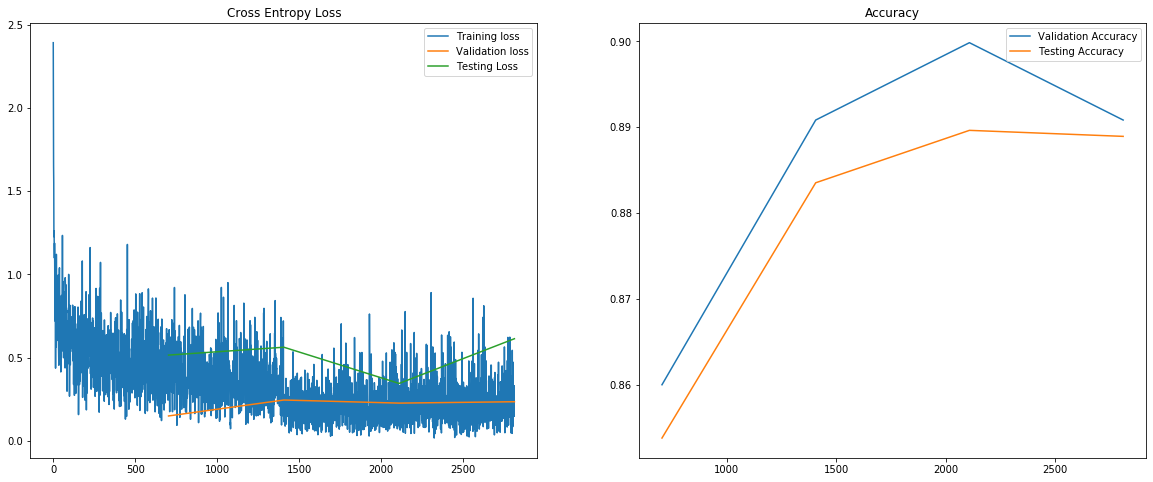

In [16]:
epochs = 10
batch_size = 32
learning_rate = 5e-4
early_stop_count = 4
regularization =True
dataloaders = load_cifar10(batch_size)

model = Model()
# model.apply(weights_init)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
)
trainer.train()
create_plots(trainer,'task4a')

In [17]:
print(trainer.TEST_ACC)

OrderedDict([(703, 0.8537660256410257),
             (1406, 0.8835136217948718),
             (2109, 0.8896233974358975),
             (2812, 0.8889222756410257)])